In [13]:
from typing import List, NamedTuple, Dict, TypeVar, Tuple
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
import requests
import csv
import math
import random
import tqdm

In [2]:
def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a','b','c','b']) == 'b'

In [3]:
def majority_vote(labels: List[str]) -> str:
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count for count in vote_counts.values() if count == winner_count])
    if num_winners == 1:
        return winner
    else:
        return majority_vote(labels[:-1])
    
assert majority_vote(['a','b','c','b']) == 'b'

majority_vote(['a','b','c','b'])

'b'

In [4]:
Vector = List[float]
def distance(v1: Vector, v2: Vector) -> float:
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(v1, v2)))

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int, labeled_points: List[LabeledPoint], new_point: Vector) -> str:

    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points, key=lambda lp: distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)

In [5]:
data = requests.get(
"https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
)
with open('iris.data', 'w') as f:
    f.write(data.text)

In [6]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
        """
        sepal_length, sepal_width, petal_length, petal_width, class
        """
        measurements = [float(value) for value in row[:-1]]
        # class is e.g. "Iris-virginica"; we just want "virginica"
        label = row[-1].split("-")[-1]
    
        return LabeledPoint(measurements, label)
    
iris_data = []
''
with open('iris.data') as f:
    reader = csv.reader(f)
    for row in reader:
        if row:  # <--- ESTO EVITA EL INDEXERROR: Solo procesa si la fila NO está vacía
            try:
                iris_data.append(parse_iris_row(row))
            except ValueError:
                # Esto ayuda por si hay una fila de encabezados o datos corruptos
                print(f"Saltando fila inválida: {row}")

# Ahora agrupamos
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

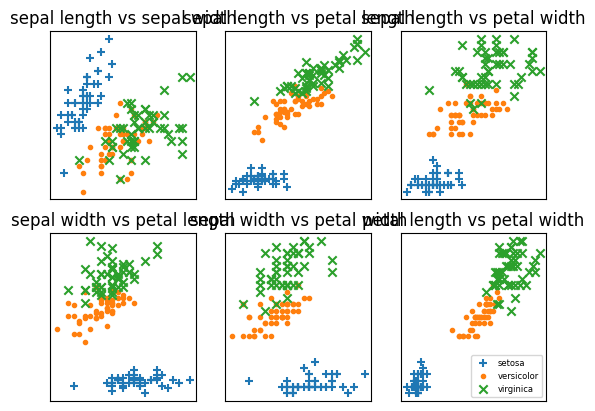

In [7]:
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i,j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']
fig, ax = plt.subplots(2, 3)
for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}")
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)
ax[-1][-1].legend(loc='lower right', prop={'size':6})
plt.show()

In [8]:

X = TypeVar('X')

def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Divide los datos en fracciones [prob, 1 - prob]"""
    data = data[:]                    # Crea una copia
    random.shuffle(data)              # Desordena
    cut = int(len(data) * prob)       # Calcula el punto de corte
    return data[:cut], data[cut:]     # Devuelve las dos partes

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.7)

assert len(iris_train) == int(0.7 * 150)
assert len(iris_test) == int(0.3 * 150)

In [10]:
# controla las veces que vemos (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0
for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    if predicted == actual:
        num_correct += 1
    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


In [11]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

In [12]:
def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

In [14]:
dimensions = range(1, 101)
avg_distances = []
min_distances = []
random.seed(0)
for dim in tqdm.tqdm(dimensions, desc='Curse of Dimensionality'):
    distances = random_distances(dim, 10000)
    avg_distances.append(sum(distances) / 10000)
    min_distances.append(min(distances))

Curse of Dimensionality: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


In [15]:
min_avg_ratio = [min_dist / avg_dist for min_dist, avg_dist in zip(min_distances, avg_distances)]